In [1]:
import re

In [4]:
url = 'https://www.youtube.com/watch?v=2_gSXyt2108&list=PLZoTAELRMXVOQPRG7VAuHL--y97opD5GQ&index=7&t=13s'
video_id_match = re.search(r'(?:v=|\/)([0-9A-Za-z_-]{11}).*', url)
print(video_id_match.group(1))

2_gSXyt2108


In [6]:
import re
import csv
import pandas as pd
from googleapiclient.discovery import build
from youtube_transcript_api import YouTubeTranscriptApi

In [9]:
def get_video_title(video_id):
    # build the youTube service
    youtube = build('youtube', 'v3', developerKey='YOUR_API_KEY')

    # fetch the video details
    request = youtube.videos().list(
        part='snippet',
        id=video_id
    )
    response = request.execute()

    # extract the title
    title = response['items'][0]['snippet']['title'] if response['items'] else 'Unknown Title'
    return title

In [10]:
get_video_title('2_gSXyt2108')

'6-Building Advanced RAG Q&A Project With Multiple Data Sources With Langchain'

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation

transcript_df = pd.read_csv('qN_2fnOPY-M_transcript.csv')
print(transcript_df.head())

  start                                      text
0  0.08  hello everyone Daniel here in this video
1   2.6      tutorial we're going to start from a
2   4.4        blank notebook and end with a full
3  6.56   retrieval augmented generation pipeline
4  9.04  or rag pipeline from scratch and best of


In [28]:
transcript_df['start'] = pd.to_numeric(transcript_df['start'], errors='coerce')

print(transcript_df.info())
print(transcript_df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7468 entries, 0 to 7467
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   start   7467 non-null   float64
 1   text    7468 non-null   object 
dtypes: float64(1), object(1)
memory usage: 116.8+ KB
None
              start
count   7467.000000
mean   10170.219004
std     5957.977745
min        0.080000
25%     4910.619500
50%    10218.040000
75%    15324.459500
max    20457.920000


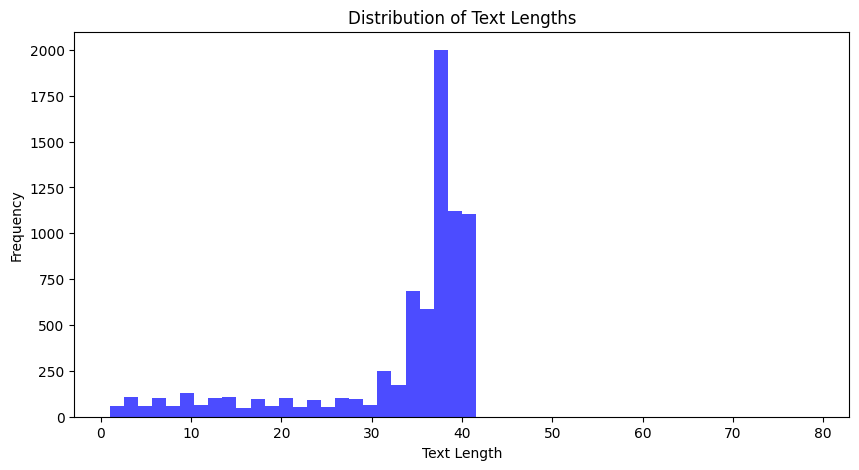

In [29]:
# distribution of text lengths
transcript_df['text_length'] = transcript_df['text'].apply(len)
plt.figure(figsize=(10, 5))
plt.hist(transcript_df['text_length'], bins=50, color='blue', alpha=0.7)
plt.title('Distribution of Text Lengths')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.show()

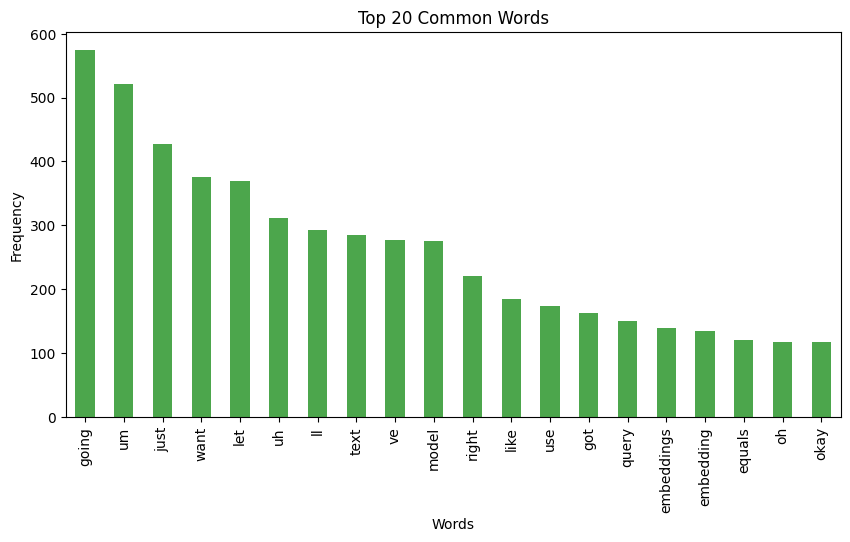

In [30]:
# most common words
vectorizer = CountVectorizer(stop_words='english')
word_counts = vectorizer.fit_transform(transcript_df['text'])
word_counts_df = pd.DataFrame(word_counts.toarray(), columns=vectorizer.get_feature_names_out())
common_words = word_counts_df.sum().sort_values(ascending=False).head(20)
plt.figure(figsize=(10, 5))
common_words.plot(kind='bar', color='green', alpha=0.7)
plt.title('Top 20 Common Words')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.show()

In [31]:
# topic Modeling using NMF
n_features = 1000
n_topics = 10
n_top_words = 10

tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
tf = tf_vectorizer.fit_transform(transcript_df['text'])
nmf = NMF(n_components=n_topics, random_state=42).fit(tf)
tf_feature_names = tf_vectorizer.get_feature_names_out()

def display_topics(model, feature_names, no_top_words):
    topics = []
    for topic_idx, topic in enumerate(model.components_):
        topic_words = [feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]
        topics.append(" ".join(topic_words))
    return topics

topics = display_topics(nmf, tf_feature_names, n_top_words)
print("\nIdentified Topics:")
for i, topic in enumerate(topics):
    print(f"Topic {i + 1}: {topic}")


Identified Topics:
Topic 1: going use write query build list right know need embeddings
Topic 2: um like search use actually rag number llm pdf smaller
Topic 3: just like right oh write code basically start need function
Topic 4: want use right query vector don look context number okay
Topic 5: let okay know right say try create look make beautiful
Topic 6: ve got query little gone okay rag right bit prompt
Topic 7: uh like llm use don tokens run using 7b data
Topic 8: text chunks pages equals output embedding generate tokens pass right
Topic 9: model embedding use id llm gemma equals language load size
Topic 10: ll right print embeddings set equals chunk start search create


In [32]:
# get topic distribution for each text segment
topic_distribution = nmf.transform(tf)

# align the lengths by trimming the extra row in topic_distribution
topic_distribution_trimmed = topic_distribution[:len(transcript_df)]

# compute the dominant topic for each text segment
transcript_df['dominant_topic'] = topic_distribution_trimmed.argmax(axis=1)

In [33]:
# analyze the content of each text segment to manually identify logical breaks
logical_breaks = []

for i in range(1, len(transcript_df)):
    if transcript_df['dominant_topic'].iloc[i] != transcript_df['dominant_topic'].iloc[i - 1]:
        logical_breaks.append(transcript_df['start'].iloc[i])

In [34]:
# consolidate the logical breaks into broader chapters
threshold = 60  # seconds
consolidated_breaks = []
last_break = None

for break_point in logical_breaks:
    if last_break is None or break_point - last_break >= threshold:
        consolidated_breaks.append(break_point)
        last_break = break_point

In [35]:
# merge consecutive breaks with the same dominant topic
final_chapters = []
last_chapter = (consolidated_breaks[0], transcript_df['dominant_topic'][0])

for break_point in consolidated_breaks[1:]:
    current_topic = transcript_df[transcript_df['start'] == break_point]['dominant_topic'].values[0]
    if current_topic == last_chapter[1]:
        last_chapter = (last_chapter[0], current_topic)
    else:
        final_chapters.append(last_chapter)
        last_chapter = (break_point, current_topic)

final_chapters.append(last_chapter)  # append the last chapter

In [36]:
# Convert the final chapters to a readable time format
chapter_points = []
chapter_names = []

for i, (break_point, topic_idx) in enumerate(final_chapters):
    chapter_time = pd.to_datetime(break_point, unit='s').strftime('%H:%M:%S')
    chapter_points.append(chapter_time)

    # get the context for the chapter name
    chapter_text = transcript_df[(transcript_df['start'] >= break_point) & (transcript_df['dominant_topic'] == topic_idx)]['text'].str.cat(sep=' ')

    # extract key phrases to create a chapter name
    vectorizer = TfidfVectorizer(stop_words='english', max_features=3)
    tfidf_matrix = vectorizer.fit_transform([chapter_text])
    feature_names = vectorizer.get_feature_names_out()
    chapter_name = " ".join(feature_names)

    chapter_names.append(f"Chapter {i+1}: {chapter_name}")

# display the final chapter points with names
print("\nFinal Chapter Points with Names:")
for time, name in zip(chapter_points, chapter_names):
    print(f"{time} - {name}")


Final Chapter Points with Names:
00:00:02 - Chapter 1: actually search um
00:01:04 - Chapter 2: don really uh
00:02:04 - Chapter 3: going just like
00:03:05 - Chapter 4: actually search um
00:04:06 - Chapter 5: got rag ve
00:06:12 - Chapter 6: query right want
00:07:15 - Chapter 7: got rag ve
00:08:15 - Chapter 8: going just like
00:09:17 - Chapter 9: chunks equals text
00:10:23 - Chapter 10: going use write
00:11:25 - Chapter 11: actually search um
00:12:25 - Chapter 12: got rag ve
00:13:26 - Chapter 13: embeddings ll time
00:14:26 - Chapter 14: know let okay
00:15:26 - Chapter 15: actually search um
00:16:28 - Chapter 16: chunks equals text
00:17:28 - Chapter 17: got rag ve
00:19:31 - Chapter 18: actually search um
00:20:31 - Chapter 19: query right want
00:21:34 - Chapter 20: know let okay
00:22:36 - Chapter 21: embedding model use
00:23:38 - Chapter 22: query right want
00:24:39 - Chapter 23: know let okay
00:25:39 - Chapter 24: query right want
00:27:43 - Chapter 25: actually sea